In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.util

LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")


from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl

from netCDF4 import Dataset
import numpy as np

Get color map from a defined number of colors

In [2]:
def get_cmap(n, name="viridis"):
    """Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name."""
    return mpl.cm.get_cmap(name, n)

Transform coordinate onto a specific projection

In [3]:
def define_box(lat1, lat2, lon1, lon2, proj) -> tuple:
    geodetic = ccrs.Geodetic()
    lon1_t, lat1_t = proj.transform_point(lon1, lat1, geodetic)
    lon2_t, lat2_t = proj.transform_point(lon1, lat2, geodetic)
    lon3_t, lat3_t = proj.transform_point(lon2, lat2, geodetic)
    lon4_t, lat4_t = proj.transform_point(lon2, lat1, geodetic)
    return lat1_t, lat2_t, lat3_t, lat4_t, lon1_t, lon2_t, lon3_t, lon4_t

Define domains of study

In [4]:
domains = dict(
        sop={
            "latlon": (5, -50, 130, -70),
            "name": "southpacific",
            "ls": "solid",
            "lw": 2,
        },
        nop={
            "latlon": (0, 50, 115, -100),
            "name": "northpacific",
            "ls": "solid",
            "lw": 2,
        },
        sio={
            "latlon": (-10, -50, 0, 115),
            "name": "southindianocean",
            "ls": "solid",
            "lw": 2,
        },
        sat1={
            "latlon": (-10, -50, -60, 359.9999999999),
            "name": "southatlantic",
            "ls": "dashed",
            "lw": 1,
        },  # cross the edge of the map
        sat2={
            "latlon": (-10, -50, 0, 20),
            "name": "southatlantic",
            "ls": "dashed",
            "lw": 1,
        },
    )

Load data

In [5]:
ncfile = Dataset(
    "../data/top_net_thermal_radiation_1959_2021_mean.nc",
    "r",
)
lons = ncfile.variables["longitude"][:]
lats = ncfile.variables["latitude"][:]
olr = ncfile.variables["ttr"][:]
olrymean = np.divide(np.multiply(olr[0], -1), 3600)
# add cyclic point
colr, clons = cartopy.util.add_cyclic_point(olrymean, lons)

Create map of the average of OLR between 1959 and 2021 overlayed by the domains of study

In [6]:
# set up plot properties
mpl.rcParams.update(mpl.rcParamsDefault)
size = 12
mpl.rcParams["text.usetex"] = False
mpl.rcParams["font.size"] = size
mpl.rcParams["axes.titlesize"] = size
mpl.rcParams["axes.labelsize"] = size
mpl.rcParams["xtick.labelsize"] = size
mpl.rcParams["ytick.labelsize"] = size
mpl.rcParams["legend.fontsize"] = size
mpl.rcParams["figure.titlesize"] = size

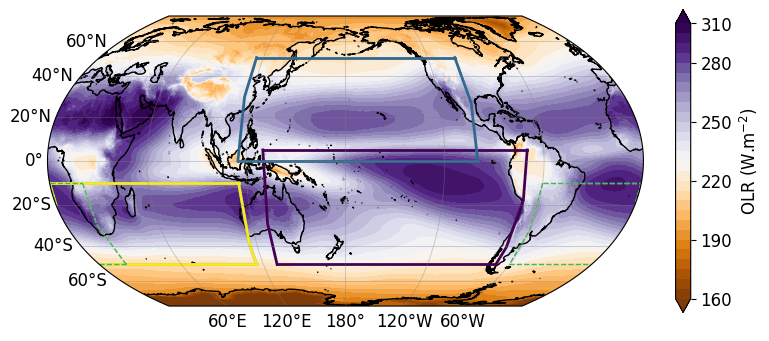

In [7]:
fig = plt.figure(figsize=(8.3, 6.6))
ax = plt.axes(projection=ccrs.EqualEarth(central_longitude=180))
fill = ax.contourf(
    clons,
    lats,
    colr,
    transform=ccrs.PlateCarree(),
    levels=range(160, 305, 5),
    cmap="PuOr",
    extend="both",
)
ax.coastlines("50m", color="black")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6, color="gray", alpha=0.4, linestyle="-")
gl.top_labels = False
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xlocator = mticker.FixedLocator([60, 120, 180, -120, -60])
#
im_ratio = colr.shape[0] / colr.shape[1]
cbar = fig.colorbar(fill, orientation="vertical", ticks=np.arange(160, 330, 30), fraction=0.047 * im_ratio)
cbar.set_label(r"OLR (W.m$^{-2}$)")
cmap = get_cmap(len(domains) - 1)
projection = ccrs.PlateCarree(central_longitude=180)

for i, (key, value) in enumerate(domains.items()):
    lat1, lat2, lon1, lon2 = value["latlon"]
    lat1_t, lat2_t, lat3_t, lat4_t, lon1_t, lon2_t, lon3_t, lon4_t = define_box(
        lat1, lat2, lon1, lon2, proj=projection
    )
    ax.plot(
        [lon1_t, lon2_t], [lat1_t, lat2_t], color=cmap(i), linewidth=value["lw"], ls=value["ls"], transform=projection
    )
    ax.plot(
        [lon2_t, lon3_t], [lat2_t, lat3_t], color=cmap(i), linewidth=value["lw"], ls=value["ls"], transform=projection
    )
    ax.plot(
        [lon4_t, lon3_t], [lat4_t, lat3_t], color=cmap(i), linewidth=value["lw"], ls=value["ls"], transform=projection
    )
    ax.plot(
        [lon1_t, lon4_t], [lat1_t, lat4_t], color=cmap(i), linewidth=value["lw"], ls=value["ls"], transform=projection
    )

    if value["name"] == "southindianocean":
        ax.plot(
            [lon1_t, lon2_t],
            [lat1_t, lat2_t],
            color=cmap(3),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )
        ax.plot(
            [lon2_t, lon3_t],
            [lat2_t, lat3_t],
            color=cmap(3),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )
        ax.plot(
            [lon4_t, lon3_t],
            [lat4_t, lat3_t],
            color=cmap(3),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )
        ax.plot(
            [lon1_t, lon4_t],
            [lat1_t, lat4_t],
            color=cmap(3),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )
    elif value["name"] == "southatlantic":
        ax.plot(
            [lon1_t, lon2_t],
            [lat1_t, lat2_t],
            color=cmap(2),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )
        ax.plot(
            [lon2_t, lon3_t],
            [lat2_t, lat3_t],
            color=cmap(2),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )
        ax.plot(
            [lon4_t, lon3_t],
            [lat4_t, lat3_t],
            color=cmap(2),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )
        ax.plot(
            [lon1_t, lon4_t],
            [lat1_t, lat4_t],
            color=cmap(2),
            linewidth=value["lw"],
            ls=value["ls"],
            transform=projection,
        )

plt.show()
fig.savefig(f"mapOLR_avg_1959-2021_domains.png", dpi=300, bbox_inches="tight")
